In [3]:
import sys
sys.path.append('../src')
from logger import log, debug
from cleaner import clean_corpus_basic_neutral
from reader import read_files
from svm_utils import get_best_tokens_dummy, transform_sentence, get_score

from sklearn.utils import shuffle
from sklearn import svm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import nltk
import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lefunes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lefunes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Leemos los archivos
neutral_corpus_raw = pd.read_csv("./samples/neutral_human_rated.csv")
# Limpiamos el dataframe
neutral_corpus = clean_corpus_basic_neutral(neutral_corpus_raw)

debug("[El corpus tiene " + str(len(neutral_corpus)) + " rows]")

#Shuffleamos el corpus
neutral_corpus = shuffle(neutral_corpus)
neutral_corpus.reset_index(inplace=True, drop=True)
neutral_corpus.head()


pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 200)

[Usando cleaner basico para samples neutrales]
[Limpiando el corpus...]
[Usando 8 threads ...]
[El corpus tiene 1000 rows]


In [5]:
# Cargamos los datos
f = open("svm-no-restricted-4-3.bin", "rb")
pickler = pickle.Unpickler(f)

best_tokens = pd.read_pickle("best_tokens_svm.bin")
model = pickler.load()

f.close()


In [6]:
def to_rate(row):
    # Aca el 1 es el componente positivo
    percentage = row[1]
    if(percentage <= 1/3):
        return "m"
    if(percentage <= 2/3):
        return "n"
    return "b"

def to_percentage(row):
    percentage = row[0]
    return '%.3f'%(row[0] * 100) + "%"

In [7]:
# Transformamos el corpus
vector_size = 3
neutral_corpus["vector"] = neutral_corpus["content"].map(lambda x: transform_sentence(x, best_tokens, vector_size))


In [8]:

# Hacemos prediccion contra el model
# Predecimos la probabilidad, porque vamos a estar dividiendo en 3 categorias
y = model.predict_proba(neutral_corpus["vector"].tolist())

# Agregamos los resultados al dataframe
neutral_corpus["prediction"] = y.tolist()

# Convertimos el vector en b/n/m
neutral_corpus["machine_rate"] = neutral_corpus["prediction"].apply(to_rate)

# Vemos cuales fallo
neutral_corpus["failed"] = neutral_corpus["human_rate"] != neutral_corpus["machine_rate"]
neutral_corpus.head()

,content,raw,human_rate,vector,prediction,machine_rate,failed
0,BUEN COLOQU ANDUV PERFECT ERA EXACT NECESIT,Bueno lo coloque y anduvo perfecto. Era exactamente lo que necesitaba.,b,"[1.0, 0.0, 0.0]","[0.131961893911151, 0.8680381060888491]",b,False
1,BUEN MOMENT CUMPL SU FUNCION NO TIEN MISM AMPERAJ ORIGINAL PER IGUAL MANER FUNCION,"Bueno Por el momento el producto cumple con su función, no tiene el mismo amperaje que original, pero de igual manera funciona",b,"[1.0, 5.0, 6.0]","[0.5521134734648843, 0.4478865265351156]",n,True
2,MAS MEN ECONOM PER BAJ CALID ECONOM PER CALID BASTANT BAJ COMPR REGAL TERMIN COMPR OTRO MAZ CART CAMBI PORQU VIEN DENTR TRUQUER ERA BAJ CALID,"Mas o menos, económica pero de baja calidad Es económico, pero la calidad es bastante baja, Lo compramos para regalo y terminamos comprando otro mazo de cartas para cambiarlo porque el que viene dentro de la truquera era de muy baja calidad.",n,"[6.0, 2.0, 6.0]","[0.9198430277770353, 0.080156972222965]",m,True
3,BUEN SER BUEN REGUL VELOC POC MAS POTENCI ALMOHADILL BLAND DEFORM,Bueno Sería bueno un regulador de velocidades y un producto con un poco más de potencia. Y la almohadilla es muy blanda y deformable,n,"[1.0, 1.0, 0.0]","[0.13224980467178304, 0.867750195328217]",b,True
4,MERD MERD PINCH PAL,Una merda Una merda pinchada en un palo ....,m,"[0.0, 0.0, 0.0]","[0.4148435387774646, 0.5851564612225354]",n,True


In [9]:

# Separamos en 3 categorias
corpus_b = neutral_corpus[neutral_corpus["human_rate"] == "b"].copy()
corpus_n = neutral_corpus[neutral_corpus["human_rate"] == "n"].copy()
corpus_m = neutral_corpus[neutral_corpus["human_rate"] == "m"].copy()

In [10]:
# Contamos el acc de cada cate

corpus_b_count = corpus_b["failed"].value_counts(normalize=True)
corpus_n_count = corpus_n["failed"].value_counts(normalize=True)
corpus_m_count = corpus_m["failed"].value_counts(normalize=True)

log("[El ratio de failed/total de la categoria neutro-bueno es: " + str(corpus_b_count[True]) + "]")
log("[El ratio de failed/total de la categoria neutro-neutro es: " + str(corpus_n_count[True]) + "]")
log("[El ratio de failed/total de la categoria neutro-malo es: " + str(corpus_m_count[True]) + "]")

[El ratio de failed/total de la categoria neutro-bueno es: 0.24190064794816415]
[El ratio de failed/total de la categoria neutro-neutro es: 0.7906976744186046]
[El ratio de failed/total de la categoria neutro-malo es: 0.3422818791946309]


Text(0, 0.5, 'Frequency')

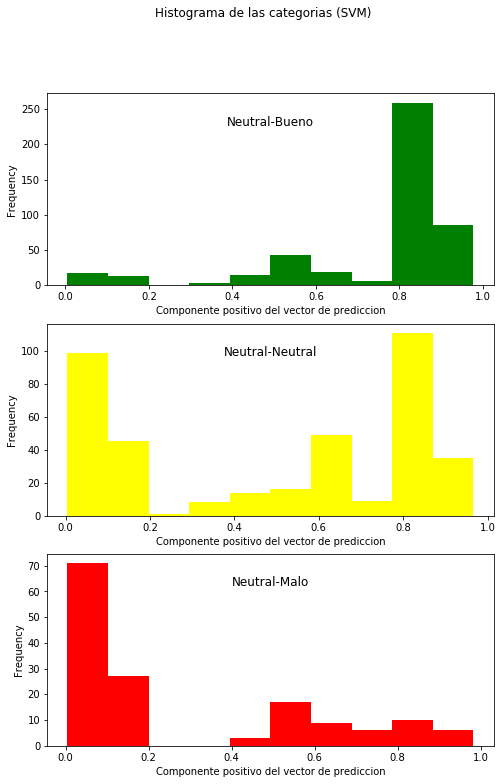

In [11]:
# Histogramas de cada categoria

hist_data_b = corpus_b["prediction"].map(lambda x: x[1])
hist_data_n = corpus_n["prediction"].map(lambda x: x[1])
hist_data_m = corpus_m["prediction"].map(lambda x: x[1])

fig = plt.figure(figsize=(8, 12))
fig.suptitle("Histograma de las categorias (SVM)")
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

n, bins, patches = ax1.hist(hist_data_b, color='green')
ax1.set_title("Neutral-Bueno", y=0.8)
ax1.set_xlabel('Componente positivo del vector de prediccion')
ax1.set_ylabel('Frequency')

n, bins, patches = ax2.hist(hist_data_n, color='yellow')
ax2.set_title("Neutral-Neutral", y=0.8)
ax2.set_xlabel('Componente positivo del vector de prediccion')
ax2.set_ylabel('Frequency')

n, bins, patches = ax3.hist(hist_data_m, color='red')
ax3.set_title("Neutral-Malo", y=0.8)
ax3.set_xlabel('Componente positivo del vector de prediccion')
ax3.set_ylabel('Frequency')


#fig.savefig('./graphs/neutral_histogram_SVM.png')

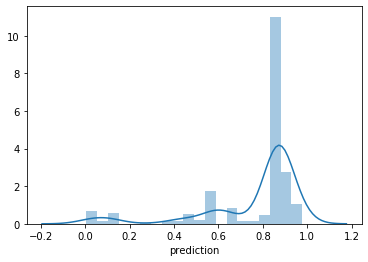

In [23]:
sns.distplot(hist_data_b, bins=20)